In [1]:
import bs4
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_ollama.llms import OllamaLLM
from langchain.chains import RetrievalQA
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
import os

USER_AGENT environment variable not set, consider setting it to identify your requests.


## **Create vector DB for RAG agents**

In [35]:
async def get_website_docs(urls_path='./data/ITFAQ_websit.txt'):
    # Clean URLs
    with open(urls_path, 'r') as f:
        urls = [url.strip() for url in f.readlines() if url.strip()]

    # Initialize loader
    loader = WebBaseLoader(web_paths=urls)

    # Collect documents asynchronously
    web_docs = []
    async for doc in loader.alazy_load():
        web_docs.append(doc)

    print(f"Number of websites loaded: {len(web_docs)}")
    return web_docs

def get_document_docs(doc_folder = './data/policies/'):
    
    doc_docs = []
    for file in os.listdir(doc_folder):
        if file.startswith('~') or file.startswith('.'):
            continue
        
        if file.endswith('.pdf'):
            loader = PyPDFLoader(os.path.join(doc_folder, file))
            doc_docs.extend(loader.load())
        elif file.endswith('.docx'):
            loader = Docx2txtLoader(os.path.join(doc_folder, file))
            doc_docs.extend(loader.load())
        
    print(f"number of documents loaded: {len(doc_docs)}")
    return doc_docs

In [36]:
hr_docs = get_document_docs()

number of documents loaded: 69


In [37]:
web_docs = await get_website_docs()

Fetching pages: 100%|##################################################################| 10/10 [00:08<00:00,  1.22it/s]


Number of websites loaded: 10


In [40]:
# embeddings = OllamaEmbeddings(model="deepseek-r1")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

C:\Users\wx-zh\anaconda3\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\wx-zh\anaconda3\envs\llm\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\wx-zh\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to 

In [42]:
def build_vectorstore(docs, embedding_model):
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    return FAISS.from_documents(chunks, embedding_model)

hr_db = build_vectorstore(hr_docs, embeddings)
it_db = build_vectorstore(web_docs, embeddings)

## **Define the router agnet**

In [43]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

In [44]:
router_prompt = PromptTemplate.from_template("""
Classify the user question into one domain: HR or IT.

Question: {question}
Answer with only 'HR' or 'IT'.
""")

In [45]:
router_llm = OllamaLLM(model="llama3")

In [46]:
router_chain = router_prompt|router_llm

## **Define the RAG agnets**

In [48]:
# rag_llm = OllamaLLM(model="deepseek-r1")
rag_llm = OllamaLLM(model="llama3")

In [49]:
rag_prompt = ChatPromptTemplate.from_template(
    """
    Answer the question based on the provied context only.
    Please provide the most accurate respone based on the question
    <context>
    {context}
    <context>
    Question: {input}
    """
)

In [50]:
hr_doc_chain = create_stuff_documents_chain(rag_llm, rag_prompt)
hr_retriever = hr_db.as_retriever()
hr_chain  = create_retrieval_chain(hr_retriever, hr_doc_chain)

it_doc_chain = create_stuff_documents_chain(rag_llm, rag_prompt)
it_retriever = it_db.as_retriever()
it_chain  = create_retrieval_chain(it_retriever, it_doc_chain)

In [54]:
response = it_chain.invoke({'input': 'What is Information Security?'})
response['answer']

'Information Security refers to the protection of information assets in order to achieve Confidentiality, Integrity and Availability (C-I-A).'

In [55]:
response = hr_chain.invoke({'input': 'What is the aim of Alcohol Policy?'})
response['answer']

"According to the provided context, the aims of the Company's Alcohol Policy are:\n\n1. To promote awareness of alcohol-related problems and addiction;\n2. To encourage a sensible approach to drinking alcohol;\n3. To ensure that the Company complies with its legal obligations;\n4. To comply with the Company's legal obligations to provide a safe and healthy working environment for all staff;\n5. To comply with all of the requirements imposed by law;\n6. To raise awareness of the effects of drug misuse and its likely symptoms;\n7. To ensure that employees are aware of their responsibilities regarding drug misuse and related problems;\n8. To indicate restrictions on drinking alcohol at work;\n9. To protect Employees from the dangers of alcohol abuse; and\n10. To support Employees with an alcohol-related problem."

## **Define the nodes**

In [58]:
from typing import TypedDict

In [59]:
class State(TypedDict):
    question: str
    # chat_history: str
    domain: str
    answer: str

In [60]:
def classify_domain(state: State) -> State:
    domain = router_chain.invoke({
        "question": state["question"]
    }).strip()

    state["domain"] = "HR" if "HR" in domain.upper() else "IT"
    return state

In [61]:
def hr_answer(state: State) -> State:
    response = hr_chain.invoke({'input': state["question"]})
    state["answer"] = response['answer']
    return state

In [62]:
def it_answer(state: State) -> State:
    response = it_chain.invoke({'input': state["question"]})
    state["answer"] = response['answer']
    return state

## **Create the graph**

In [63]:
from langgraph.graph import StateGraph, END, START

In [65]:
def rounter_node(state:State)->State:
    if state["domain"] == "HR":
        return "HR"
    else:
        return "IT"

In [66]:
graph = StateGraph(State)

graph.add_node("cls_node", classify_domain)
graph.add_node("hr_rag", hr_answer)
graph.add_node("it_rag", it_answer)

graph.add_edge(START, 'cls_node')
graph.add_conditional_edges('cls_node', rounter_node, {"HR": "hr_rag", "IT": "it_rag"})
graph.add_edge('hr_rag', END)
graph.add_edge('it_rag', END)

app = graph.compile()

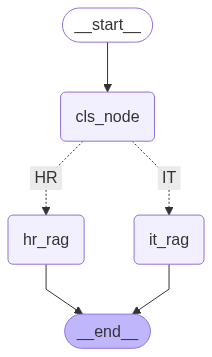

In [67]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## **Demo**

In [68]:
result = app.invoke({'question': 'What is Information Security?'})
result

{'question': 'What is Information Security?',
 'domain': 'IT',
 'answer': 'Information Security refers to the protection of information assets in order to achieve Confidentiality, Integrity, and Availability (C-I-A).'}

In [69]:
result = app.invoke({'question': 'What is the aim of Alcohol Policy?'})
result

{'question': 'What is the aim of Alcohol Policy?',
 'domain': 'HR',
 'answer': "The aim of the Company's Alcohol Policy is to:\n\n* Promote awareness of alcohol related problems and addiction\n* Encourage a sensible approach to drinking alcohol\n* Ensure that the Company complies with its legal obligations\n* Comply with the Company’s legal obligations to provide a safe and healthy working environment for all staff\n* Comply with all of the requirements imposed by law\n* Raise awareness of the effects of drug misuse and its likely symptoms\n* Ensure that employees are aware of their responsibilities regarding drug misuse and related problems\n* Indicate restrictions on drinking alcohol at work\n* Protect Employees from the dangers of alcohol abuse\n* Support Employees with an alcohol related problem"}